# **Medicine Recommendation System**

#### Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("pastel")
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

#### Fetching the Dataset

In [5]:
data = pd.read_csv("mdwu.csv")

In [6]:
data.shape

(253973, 11)

In [7]:
data.head(3)

,id,name,price,Is_discontinued,manufacturer_name,short_composition1,short_composition2,medicine_desc,side_effects,drug_interactions,reason
0,1,Augmentin 625 Duo Tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,Amoxycillin (500mg),Clavulanic Acid (125mg),Augmentin 625 Duo Tablet is a penicillin-type ...,"Vomiting,Nausea,Diarrhea","{""drug"": [], ""brand"": [], ""effect"": []}",Bacterial Infections
1,2,Azithral 500 Tablet,132.36,False,Alembic Pharmaceuticals Ltd,Azithromycin (500mg),NaN,Azithral 500 Tablet is an antibiotic used to t...,"Vomiting,Nausea,Abdominal pain,Diarrhea","{""drug"": [""Astemizole"", ""Ebastine"", ""Mizolasti...",Bacterial Infections
2,3,Ascoril LS Syrup,118.00,False,Glenmark Pharmaceuticals Ltd,Ambroxol (30mg/5ml),Levosalbutamol (1mg/5ml),Ascoril LS Syrup is a combination medicine use...,"Nausea,Vomiting,Diarrhea,Upset stomach,Stomach...","{""drug"": [], ""brand"": [], ""effect"": []}",Cough and Cold


#### Pre-Processing (Cleaning the Data)

In [9]:
# Filtering out the discontinued medicines
data = data[data['Is_discontinued'] == False].reset_index(drop=True)

In [10]:
# Filling in missing values in text columns with empty strings
text_cols = ['short_composition1', 'short_composition2', 'medicine_desc', 'side_effects', 'reason']
for col in text_cols:
    data[col] = data[col].fillna('')

In [11]:
data.isnull().sum()

id                         0
name                       0
price                      0
Is_discontinued            0
manufacturer_name          0
short_composition1         0
short_composition2         0
medicine_desc              0
side_effects               0
drug_interactions     239220
reason                     0
dtype: int64

In [12]:
data.duplicated().sum()

0

In [13]:
data['reason'] = data['reason'].fillna('').str.lower()
data['short_composition1'] = data['short_composition1'].fillna('').str.lower()
data['short_composition2'] = data['short_composition2'].fillna('').str.lower()
data['side_effects'] = data['side_effects'].fillna('').str.lower()

#### Exploring the Data (EDA)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246068 entries, 0 to 246067
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  246068 non-null  int64  
 1   name                246068 non-null  object 
 2   price               246068 non-null  float64
 3   Is_discontinued     246068 non-null  bool   
 4   manufacturer_name   246068 non-null  object 
 5   short_composition1  246068 non-null  object 
 6   short_composition2  246068 non-null  object 
 7   medicine_desc       246068 non-null  object 
 8   side_effects        246068 non-null  object 
 9   drug_interactions   6848 non-null    object 
 10  reason              246068 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 19.0+ MB


In [16]:
print(data['price'].describe())

count    246068.000000
mean        265.002121
std        3028.003408
min           0.000000
25%          48.000000
50%          79.000000
75%         140.000000
max      436000.000000
Name: price, dtype: float64


###### Top Manufacturers Bar Plot

In [18]:
print(data['manufacturer_name'].nunique())
print(data['manufacturer_name'].value_counts().head(10))

7641
manufacturer_name
Sun Pharmaceutical Industries Ltd    2542
Intas Pharmaceuticals Ltd            2169
Cipla Ltd                            2050
Torrent Pharmaceuticals Ltd          1801
Alkem Laboratories Ltd               1690
Lupin Ltd                            1587
Zydus Cadila                         1551
Micro Labs Ltd                       1188
Abbott                               1131
Macleods Pharmaceuticals Pvt Ltd     1090
Name: count, dtype: int64


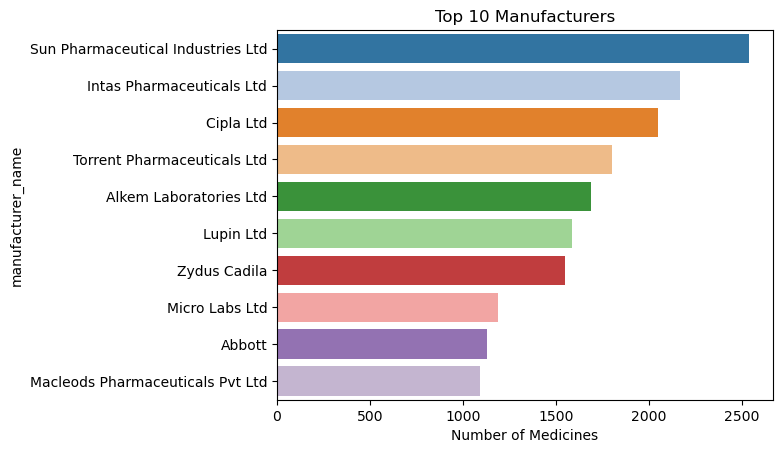

In [19]:
top_manufacturers = data['manufacturer_name'].value_counts().head(10)
sns.barplot(
    x=top_manufacturers.values,
    y=top_manufacturers.index,
    palette="tab20"
)
plt.xlabel('Number of Medicines')
plt.title('Top 10 Manufacturers')
plt.show()

###### Most Common Compositions

In [21]:
print(data['short_composition1'].value_counts().head())
print(data['short_composition2'].value_counts().head())

short_composition1
aceclofenac (100mg)     6848
domperidone (30mg)      5068
cefixime (200mg)        3473
diclofenac (50mg)       3099
domperidone (10mg)      3055
Name: count, dtype: int64
short_composition2
                         136748
 rabeprazole (20mg)        4700
 paracetamol (325mg)       4457
 paracetamol (325mg)       4386
 pantoprazole (40mg)       2862
Name: count, dtype: int64


###### Side Effects WordCloud

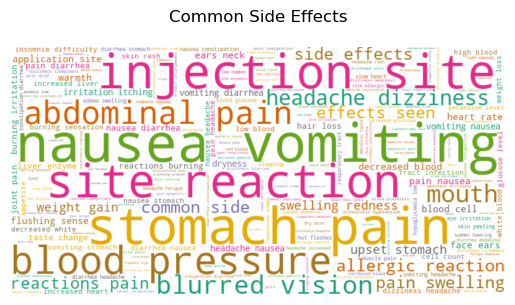

In [23]:
wc = WordCloud(width=800,
               height=400,
               background_color='white',
               colormap='Dark2').generate(' '.join(data['side_effects'].dropna()))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Common Side Effects\n')
plt.show()

###### Crosstab for: Is Discontinued & Manufacturer

In [25]:
print(pd.crosstab(data['manufacturer_name'], data['Is_discontinued']))

Is_discontinued                  False
manufacturer_name                     
10 Drug Mart                        26
3A Pharmaceuticals                   8
3C Health Solution Pvt Ltd          27
3D Healthcare                       56
3M India Limited                     1
...                                ...
e-derma  Pharma India Pvt. Ltd.     17
kalal & Saiyed Pharma Pvt Ltd        2
kartilaze Care Limited               3
rynel clifton pharma pvt. ltd        2
savoy Biotech                       42

[7641 rows x 1 columns]


###### Outlier Detection

In [27]:
# Expensive Medicine
print(data.loc[data['price'] > data['price'].quantile(0.99)])

            id                                        name     price  \
91          97                   AntiD 300mcg/ml Injection   3039.42   
248        263          Alburel 20gm Solution for Infusion   7325.23   
274        295                          Axcer  90mg Tablet   3600.00   
362        393                     Actilyse 50mg Injection  49899.00   
466        504  Aplevant 1.5mg Pre-filled Pen (0.5ml Each)   4998.00   
...        ...                                         ...       ...   
244398  252280                  Zymmune 100mg/ml Injection   6170.00   
244766  252657                       Zomibet 2mg Injection  12200.00   
244885  252776                      Zifonate 4mg Injection   2800.00   
244955  252846                        Zavedos 25mg Capsule   6525.00   
245935  253841             Zyonem S 1000mg/500mg Injection   2950.00   

        Is_discontinued                  manufacturer_name  \
91                False       Bharat Serums & Vaccines Ltd   
248        

In [28]:
# Cheap Medicine
print(data.loc[data['price'] > data['price'].quantile(0.01)])

            id                           name   price  Is_discontinued  \
0            1       Augmentin 625 Duo Tablet  223.42            False   
1            2            Azithral 500 Tablet  132.36            False   
2            3               Ascoril LS Syrup  118.00            False   
3            4           Allegra 120mg Tablet  218.81            False   
4            5                 Avil 25 Tablet   10.96            False   
...        ...                            ...     ...              ...   
246063  253969  Ziyapod 100mg Oral Suspension   62.30            False   
246064  253970            Zemhart 30mg Tablet   54.00            False   
246065  253971              Zivex 25mg Tablet   57.00            False   
246066  253972        ZI Fast 500mg Injection  152.00            False   
246067  253973      Zyvocol 1% Dusting Powder  110.00            False   

                            manufacturer_name            short_composition1  \
0        Glaxo SmithKline Pharma

In [29]:
data['medicine_desc']

0         Augmentin 625 Duo Tablet is a penicillin-type ...
1         Azithral 500 Tablet is an antibiotic used to t...
2         Ascoril LS Syrup is a combination medicine use...
3         Allegra 120mg Tablet is an anti-allergy medici...
4         Avil 25 Tablet is an antiallergic medication u...
                                ...                        
246063                                                     
246064                                                     
246065                                                     
246066                                                     
246067                                                     
Name: medicine_desc, Length: 246068, dtype: object

In [30]:
def split_sentences(text):
    return re.sub(r'([.!?])\s+', r'\1\n', text.strip())

data['medicine_desc_split'] = data['medicine_desc'].apply(split_sentences)
print(data['medicine_desc_split'].iloc[0])

Augmentin 625 Duo Tablet is a penicillin-type of antibiotic that helps your body fight infections caused by bacteria.
It is used to treat infections of the lungs (e.g., pneumonia), ear, nasal sinus, urinary tract, skin and soft tissue.
It will not work for viral infections such as the common cold.Augmentin 625 Duo Tablet is best taken with a meal to reduce the chance of a stomach upset.
You should take it regularly at evenly spaced intervals as per the schedule prescribed by your doctor.
Taking it at the same time every day will help you to remember to take it.
The dose will depend on what you are being treated for, but you should always complete a full course of this antibiotic as prescribed by your doctor.
Do not stop taking it until you have finished, even when you feel better.
If you stop taking it early, some bacteria may survive and the infection may come back or worsen.The most common side effects of this medicine include vomiting, nausea, and diarrhea.
These are usually mild bu

In [31]:
# Combining the meaningful text features into one string for vectorization
def combine_features(row):
    return ' '.join([row['short_composition1'],
                     row['short_composition2'],
                     row['medicine_desc'],
                     row['side_effects'],
                     row['reason']])

data['combined_text'] = data.apply(combine_features, axis=1)

In [32]:
def parse_interactions(drug_interactions_str):
    try:
        return json.loads(drug_interactions_str.replace("'", "\""))
    except:
        return {"drug": [], "brand": [], "effect": []}

data['parsed_interactions'] = data['drug_interactions'].apply(parse_interactions)

#### TF - IDF Vectorization & Count Vectorization

In [34]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf.fit_transform(data['combined_text'])

In [35]:
count_vec = CountVectorizer(stop_words='english', max_features=10000)
count_matrix = count_vec.fit_transform(data['combined_text'])

In [36]:
# Helper function for interaction risk checking between two medicines
def has_interaction(med1_idx, med2_idx):
    med1_interactions = data.loc[med1_idx, 'parsed_interactions']['drug']
    med2_name = data.loc[med2_idx, 'name']
    med2_interactions = data.loc[med2_idx, 'parsed_interactions']['drug']
    med1_name = data.loc[med1_idx, 'name']
    # Check if med2 name is in med1's interaction list or vice versa
    return (med2_name in med1_interactions) or (med1_name in med2_interactions)

#### Recommending Similar Medicines based on Composition 

In [38]:
def recommend_medicines(medicine_name, matrix, top_n=5, filter_interactions=True):
    if medicine_name not in data['name'].values:
        print(f"Medicine '{medicine_name}' not found.")
        return
    idx = data[data['name'] == medicine_name].index[0]
    sim = cosine_similarity(matrix[idx], matrix).flatten()
    result = []
    for i, score in enumerate(sim):
        if i != idx and (not filter_interactions or not has_interaction(idx, i)):
            result.append((i, score))
    result.sort(key=lambda x: x[1], reverse=True)
    # PrettyTable for top N results
    table = PrettyTable()
    table.field_names = ["Medicine Name", "Price", "Manufacturer", "Similarity Score"]
    for i, score in result[:top_n]:
        med = data.loc[i]
        table.add_row([med['name'], f"{med['price']:.2f}", med['manufacturer_name'], f"{score:.3f}"])
    print(f"Top {top_n} recommended medicines similar to '{medicine_name}':")
    print(table)

In [39]:
print("TF-IDF recommendations for 'Augmentin 625 Duo Tablet':")
recommend_medicines('Augmentin 625 Duo Tablet', tfidf_matrix, top_n=5)

TF-IDF recommendations for 'Augmentin 625 Duo Tablet':
Top 5 recommended medicines similar to 'Augmentin 625 Duo Tablet':
+-------------------------------+--------+--------------------------------------+------------------+
|         Medicine Name         | Price  |             Manufacturer             | Similarity Score |
+-------------------------------+--------+--------------------------------------+------------------+
|   Augmentin 1000 Duo Tablet   | 601.45 | Glaxo SmithKline Pharmaceuticals Ltd |      0.943       |
| Augmentin Duo Oral Suspension | 67.20  | Glaxo SmithKline Pharmaceuticals Ltd |      0.930       |
|      Augmentin 375 Tablet     | 229.00 | Glaxo SmithKline Pharmaceuticals Ltd |      0.906       |
|       Clavam 625 Tablet       | 223.32 |        Alkem Laboratories Ltd        |      0.900       |
|      Novaclav 625 Tablet      | 134.06 |              Cipla Ltd               |      0.899       |
+-------------------------------+--------+----------------------------

In [40]:
print("\nCountVectorizer recommendations for 'Augmentin 625 Duo Tablet':")
recommend_medicines('Augmentin 625 Duo Tablet', count_matrix, top_n=5)


CountVectorizer recommendations for 'Augmentin 625 Duo Tablet':
Top 5 recommended medicines similar to 'Augmentin 625 Duo Tablet':
+---------------------------+--------+---------------------------------------+------------------+
|       Medicine Name       | Price  |              Manufacturer             | Similarity Score |
+---------------------------+--------+---------------------------------------+------------------+
| Augmentin 1000 Duo Tablet | 601.45 |  Glaxo SmithKline Pharmaceuticals Ltd |      0.978       |
|    Amoxyclav 625 Tablet   | 223.27 |                 Abbott                |      0.973       |
|    Bactoclav 625 Tablet   | 201.70 |             Micro Labs Ltd            |      0.973       |
|     Clavam 625 Tablet     | 223.32 |         Alkem Laboratories Ltd        |      0.973       |
|     Indclav 625 Tablet    | 223.32 | Indchemie Health Specialities Pvt Ltd |      0.973       |
+---------------------------+--------+---------------------------------------+------

In [41]:
print("TF-IDF recommendations for 'Ascoril LS Syrup':")
recommend_medicines('Ascoril LS Syrup', tfidf_matrix, top_n=5)

TF-IDF recommendations for 'Ascoril LS Syrup':
Top 5 recommended medicines similar to 'Ascoril LS Syrup':
+------------------------+--------+---------------------------------+------------------+
|     Medicine Name      | Price  |           Manufacturer          | Similarity Score |
+------------------------+--------+---------------------------------+------------------+
|  Grilinctus-LS Syrup   | 115.00 | Wardex Pharmaceutical Pvt. Ltd. |      0.954       |
|   New Brozeet Syrup    | 121.90 |   Alembic Pharmaceuticals Ltd   |      0.872       |
|   Kofarest-PD Syrup    | 124.41 | Centaur Pharmaceuticals Pvt Ltd |      0.862       |
|   Tusq-X Expectorant   | 96.00  |   Blue Cross Laboratories Ltd   |      0.852       |
| Ascoril SF Expectorant | 135.00 |   Glenmark Pharmaceuticals Ltd  |      0.849       |
+------------------------+--------+---------------------------------+------------------+


In [42]:
print("\nCountVectorizer recommendations for 'Ascoril LS Syrup':")
recommend_medicines('Ascoril LS Syrup', count_matrix, top_n=5)


CountVectorizer recommendations for 'Ascoril LS Syrup':
Top 5 recommended medicines similar to 'Ascoril LS Syrup':
+-----------------------------------+--------+----------------------------------+------------------+
|           Medicine Name           | Price  |           Manufacturer           | Similarity Score |
+-----------------------------------+--------+----------------------------------+------------------+
|        Grilinctus-LS Syrup        | 115.00 | Wardex Pharmaceutical Pvt. Ltd.  |      0.989       |
|         Kofarest-PD Syrup         | 124.41 | Centaur Pharmaceuticals Pvt Ltd  |      0.941       |
|         New Brozeet Syrup         | 121.90 |   Alembic Pharmaceuticals Ltd    |      0.941       |
|         Tusq-X Expectorant        | 96.00  |   Blue Cross Laboratories Ltd    |      0.935       |
| Macbery-XT Expectorant Sugar Free | 108.50 | Macleods Pharmaceuticals Pvt Ltd |      0.919       |
+-----------------------------------+--------+------------------------------

#### Medicine Recommendation System Based on Symptoms

In [44]:
def recommend_by_symptom(symptom_text, top_n=10):
    # Vectorize the input symptom text
    symptom_vec = tfidf.transform([symptom_text])
    # Calculate similarity between symptom and all combined medicine texts
    sim_scores = cosine_similarity(symptom_vec, tfidf_matrix).flatten()
    # Get indices of top_n similar medicines
    top_indices = sim_scores.argsort()[::-1][:top_n]
    # Prepare table for output
    table = PrettyTable()
    table.field_names = ["Medicine Name", "Price", "Manufacturer", "Similarity Score", "Reason"]
    for idx in top_indices:
        med = data.loc[idx]
        table.add_row([
            med['name'],
            f"{med['price']:.2f}",
            med['manufacturer_name'],
            f"{sim_scores[idx]:.3f}",
            med['reason']
        ])
    print(f"Top {top_n} TF-IDF medicine recommendations for '{symptom_text}'")
    print(table)

In [45]:
def recommend_by_symptom_count(symptom_text, top_n=10):
    # Vectorize the input symptom text using the CountVectorizer
    symptom_vec = count_vec.transform([symptom_text])
    # Calculate similarity between symptom and all combined medicine texts
    sim_scores = cosine_similarity(symptom_vec, count_matrix).flatten()
    # Get indices of top_n similar medicines
    top_indices = sim_scores.argsort()[::-1][:top_n]
    # Prepare table for output
    table = PrettyTable()
    table.field_names = ["Medicine Name", "Price", "Manufacturer", "Similarity Score", "Reason"]
    for idx in top_indices:
        med = data.loc[idx]
        table.add_row([
            med['name'],
            f"{med['price']:.2f}",
            med['manufacturer_name'],
            f"{sim_scores[idx]:.3f}",
            med['reason']])
    print(f"Top {top_n} CountVectorizer recommendations for '{symptom_text}'")
    print(table)

In [46]:
recommend_by_symptom("fever", top_n=10)  

Top 10 TF-IDF medicine recommendations for 'fever'
+---------------------------+---------+--------------------------------------+------------------+--------+
|       Medicine Name       |  Price  |             Manufacturer             | Similarity Score | Reason |
+---------------------------+---------+--------------------------------------+------------------+--------+
|      Stamaril Vaccine     | 2230.00 |          Sanofi India  Ltd           |      0.344       | fever  |
|  Typho VI 25mcg Injection |  525.00 |      Intas Pharmaceuticals Ltd       |      0.340       | fever  |
| Typho VI 2.5mcg Injection |  820.36 |      Intas Pharmaceuticals Ltd       |      0.338       | fever  |
|  Bio Typh 25mcg Injection |  160.00 |            Bharat Biotech            |      0.338       | fever  |
|     Peda Typh Vaccine     | 1250.00 |        Biomed Pharmaceuticals        |      0.329       | fever  |
|     Fevastin Injection    |  16.30  |        Tablets India Limited         |      0.289    

In [47]:
recommend_by_symptom_count("fever", top_n=10)

Top 10 CountVectorizer recommendations for 'fever'
+---------------------------+---------+--------------------------------------+------------------+--------+
|       Medicine Name       |  Price  |             Manufacturer             | Similarity Score | Reason |
+---------------------------+---------+--------------------------------------+------------------+--------+
|      Stamaril Vaccine     | 2230.00 |          Sanofi India  Ltd           |      0.379       | fever  |
|  Typho VI 25mcg Injection |  525.00 |      Intas Pharmaceuticals Ltd       |      0.363       | fever  |
|  Bio Typh 25mcg Injection |  160.00 |            Bharat Biotech            |      0.363       | fever  |
| Typho VI 2.5mcg Injection |  820.36 |      Intas Pharmaceuticals Ltd       |      0.363       | fever  |
|     Peda Typh Vaccine     | 1250.00 |        Biomed Pharmaceuticals        |      0.361       | fever  |
|    Enteroshield Vaccine   | 1940.00 |                Abbott                |      0.325    

In [48]:
recommend_by_symptom("bacterial infection", top_n=10)

Top 10 TF-IDF medicine recommendations for 'bacterial infection'
+------------------------+-------+-------------------------------------+------------------+----------------------+
|     Medicine Name      | Price |             Manufacturer            | Similarity Score |        Reason        |
+------------------------+-------+-------------------------------------+------------------+----------------------+
|  Gentamycin Eye Drop   |  8.00 |      Cadila Pharmaceuticals Ltd     |      0.277       | bacterial infections |
|   Andremide Eye Drop   | 21.88 |      Intas Pharmaceuticals Ltd      |      0.277       | bacterial infections |
|     Rosal Eye Drop     | 53.17 |    Kaizen Pharmaceuticals Pvt Ltd   |      0.277       | bacterial infections |
|    Alight Eye Drop     | 12.18 |        Leeford Healthcare Ltd       |      0.277       | bacterial infections |
|  Locula 10% Eye Drop   | 31.00 | East India Pharmaceutical Works Ltd |      0.272       | bacterial infections |
|  Locula 20% E

In [49]:
recommend_by_symptom_count("bacterial infection", top_n=10)

Top 10 CountVectorizer recommendations for 'bacterial infection'
+------------------------+-------+-------------------------------------+------------------+----------------------+
|     Medicine Name      | Price |             Manufacturer            | Similarity Score |        Reason        |
+------------------------+-------+-------------------------------------+------------------+----------------------+
|  Gentamycin Eye Drop   |  8.00 |      Cadila Pharmaceuticals Ltd     |      0.320       | bacterial infections |
|    Alight Eye Drop     | 12.18 |        Leeford Healthcare Ltd       |      0.312       | bacterial infections |
|     Rosal Eye Drop     | 53.17 |    Kaizen Pharmaceuticals Pvt Ltd   |      0.312       | bacterial infections |
|   Andremide Eye Drop   | 21.88 |      Intas Pharmaceuticals Ltd      |      0.312       | bacterial infections |
|   Ocu Sulf Eye Drop    |  9.93 |              Cipla Ltd              |      0.310       | bacterial infections |
|  Locula 20% E

#### Comparing the the Performance of the Models

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [52]:
X = data['medicine_desc'].fillna('') + ' ' + data['side_effects'].fillna('')
y = data['reason']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Defining pipelines for TF-IDF and Count Vectorizer with Logistic Regression
pipeline_tfidf = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(max_iter=1000))
pipeline_count = make_pipeline(CountVectorizer(stop_words='english'), LogisticRegression(max_iter=1000))

In [55]:
# Training
pipeline_tfidf.fit(X_train, y_train)
pipeline_count.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [56]:
# Predicting
pred_tfidf = pipeline_tfidf.predict(X_test)
pred_count = pipeline_count.predict(X_test)

In [57]:
# Print classification reports for TF-IDF
print("TF-IDF + Logistic Regression Performance:\n")
print(classification_report(y_test, pred_tfidf))

TF-IDF + Logistic Regression Performance:

                             precision    recall  f1-score   support

         allergic reactions       1.00      0.92      0.96        60
       bacterial infections       0.96      0.99      0.97       461
             cough and cold       0.97      0.90      0.93        87
                   diabetes       1.00      0.83      0.91        47
                      fever       1.00      0.70      0.82        53
 gastrointestinal infection       0.96      0.91      0.93        47
general use / not specified       1.00      1.00      1.00     48015
               hypertension       0.92      0.86      0.89        88
      pain and inflammation       0.90      0.97      0.93       344
     respiratory conditions       1.00      0.58      0.74        12

                   accuracy                           1.00     49214
                  macro avg       0.97      0.87      0.91     49214
               weighted avg       1.00      1.00      1.00

In [58]:
print("Count Vectorizer + Logistic Regression Performance:\n")
print(classification_report(y_test, pred_count))

Count Vectorizer + Logistic Regression Performance:

                             precision    recall  f1-score   support

         allergic reactions       1.00      0.97      0.98        60
       bacterial infections       0.99      0.99      0.99       461
             cough and cold       0.99      1.00      0.99        87
                   diabetes       1.00      1.00      1.00        47
                      fever       1.00      1.00      1.00        53
 gastrointestinal infection       0.98      0.96      0.97        47
general use / not specified       1.00      1.00      1.00     48015
               hypertension       0.96      0.98      0.97        88
      pain and inflammation       0.99      0.99      0.99       344
     respiratory conditions       1.00      0.92      0.96        12

                   accuracy                           1.00     49214
                  macro avg       0.99      0.98      0.98     49214
               weighted avg       1.00      1.00

#### Designing the UI

In [60]:
%gui qt

In [61]:
import sys

In [62]:
from PyQt5.QtWidgets import (QApplication, QMainWindow, QTabWidget, QWidget, QLabel, QLineEdit,
    QPushButton, QVBoxLayout, QTableWidget, QTableWidgetItem, QMessageBox)

In [63]:
class MedicineSimilarityApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Similar Medicine Recommender")
        self.init_ui()

    def init_ui(self):
        self.label = QLabel("Enter Medicine Name:")
        self.input_box = QLineEdit()
        self.button = QPushButton("Find Similar Medicines")
        self.result_table = QTableWidget()

        self.button.clicked.connect(self.handle_recommendation)

        layout = QVBoxLayout()
        layout.addWidget(self.label)
        layout.addWidget(self.input_box)
        layout.addWidget(self.button)
        layout.addWidget(self.result_table)

        self.setLayout(layout)
        self.resize(800, 500)

    def handle_recommendation(self):
        med_name = self.input_box.text().strip()
        if not med_name:
            QMessageBox.warning(self, "Input Error", "Please enter a medicine name.")
            return

        if med_name not in data['name'].values:
            QMessageBox.critical(self, "Not Found", f"'{med_name}' not found in the dataset.")
            return

        try:
            idx = data[data['name'] == med_name].index[0]
            query_vec = tfidf_matrix[idx]
            cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()

            sim_scores = list(enumerate(cosine_sim))
            filtered_scores = [(i, score) for i, score in sim_scores if i != idx and not has_interaction(idx, i)]
            filtered_scores = sorted(filtered_scores, key=lambda x: x[1], reverse=True)[:5]

            self.result_table.setRowCount(len(filtered_scores))
            self.result_table.setColumnCount(4)
            self.result_table.setHorizontalHeaderLabels(["Medicine", "Price", "Manufacturer", "Score"])

            for row, (i, score) in enumerate(filtered_scores):
                med = data.loc[i]
                self.result_table.setItem(row, 0, QTableWidgetItem(med['name']))
                self.result_table.setItem(row, 1, QTableWidgetItem(f"{med['price']:.2f}"))
                self.result_table.setItem(row, 2, QTableWidgetItem(med['manufacturer_name']))
                self.result_table.setItem(row, 3, QTableWidgetItem(f"{score:.3f}"))

        except Exception as e:
            QMessageBox.critical(self, "Error", str(e))

In [64]:
class SymptomRecommender(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Medicine Recommendation System")
        self.init_ui()

    def init_ui(self):
        self.label = QLabel("Enter Symptom or Condition:")
        self.input_box = QLineEdit()
        self.button = QPushButton("Recommend Medicines")
        self.result_table = QTableWidget()

        self.button.clicked.connect(self.handle_recommendation)

        layout = QVBoxLayout()
        layout.addWidget(self.label)
        layout.addWidget(self.input_box)
        layout.addWidget(self.button)
        layout.addWidget(self.result_table)

        self.setLayout(layout)
        self.resize(800, 500)

    def handle_recommendation(self):
        symptom = self.input_box.text().strip()
        if not symptom:
            QMessageBox.warning(self, "Input Error", "Please enter a symptom or condition.")
            return

        try:
            # Vectorizing and computing similarity
            symptom_vec = tfidf.transform([symptom])
            sim_scores = cosine_similarity(symptom_vec, tfidf_matrix).flatten()
            top_n = 10
            top_indices = sim_scores.argsort()[::-1][:top_n]

            self.result_table.setRowCount(top_n)
            self.result_table.setColumnCount(5)
            self.result_table.setHorizontalHeaderLabels(["Medicine", "Price", "Manufacturer", "Score", "Reason"])

            for row, idx in enumerate(top_indices):
                med = data.loc[idx]
                self.result_table.setItem(row, 0, QTableWidgetItem(med['name']))
                self.result_table.setItem(row, 1, QTableWidgetItem(f"{med['price']:.2f}"))
                self.result_table.setItem(row, 2, QTableWidgetItem(med['manufacturer_name']))
                self.result_table.setItem(row, 3, QTableWidgetItem(f"{sim_scores[idx]:.3f}"))
                self.result_table.setItem(row, 4, QTableWidgetItem(med['reason']))
        except Exception as e:
            QMessageBox.critical(self, "Error", str(e))

In [65]:
class CombinedRecommender(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Medicine Recommender (Composition + Symptoms)")
        self.resize(900, 600)

        tabs = QTabWidget()
        tabs.addTab(MedicineSimilarityApp(), "By Composition / Name")
        tabs.addTab(SymptomRecommender(), "By Symptoms / Condition")

        self.setCentralWidget(tabs)

def start_app():
    app = QApplication.instance()
    if not app:
        app = QApplication(sys.argv)
        created = True
    else:
        created = False

    window = CombinedRecommender()
    window.show()

    if created:
        sys.exit(app.exec_())

if __name__ == '__main__':
    start_app()

In [66]:
app = QApplication.instance() 
window = CombinedRecommender()
window.show()